TODO on the KS optimizer script:
- remove trivial axis in energy [shape is now `(1000, 1)`]

In [1]:
import os.path

import os
import dftqml.utils
import matplotlib.pyplot as plt
import numpy as np

DFTQML_PATH = os.path.abspath(os.getcwd() + "/../")

In [2]:
os.chdir(os.path.join(DFTQML_PATH, "main"))

In [3]:
KS_DIR = "kohn-sham"
DATA_DIR = "data-h5"
INITS = ["cheat", "random", "uniform"]
N_SPLITS = 5
EXACT = "exact"
N_DATA_MODEL = 1000
N_DATA_TEST = 1000
POTENTIALS = "potentials.h5"

HARMONIC_EXACT = "harmonic_exact"
HARMONIC_POTENTIALS = "harmonic_potentials"
N_HARMONIC = 400
N_HARMONIC_START = 0

def data_path(L, N, U, source):
    return os.path.join(DATA_DIR, f"L{L}-N{N}-U{U}", source)


def ks_path(L, N, U, source, init, split):
    return os.path.join(
        KS_DIR, init, f"L{L}-N{N}-U{U}", source, f"ndata{N_DATA_TEST}", f"split{split}"
    )

def harmonic_ks_path(L, N, U, source, init, split):
    return os.path.join(
        KS_DIR, 'harmonic', init, f"L{L}-N{N}-U{U}", source, f"ndata{N_DATA_TEST}", f"split{split}"
    )

def load_ks(L, N, U, source, init, split, *, potentials, harmonic=False):
    if harmonic:
        densities, energies =  dftqml.utils.load_dft_data(
            harmonic_ks_path(L, N, U, source, init, split), N_HARMONIC, first_idx=N_HARMONIC_START
        )
    else:
        densities, energies =  dftqml.utils.load_dft_data(
            ks_path(L, N, U, source, init, split), N_DATA_TEST, first_idx=N_DATA_MODEL
        )
    energies = energies[:, 0]  # TODO remove once script is fixed
    return densities, energies

def get_potential_energies(potentials, densities):
    return np.einsum('ij,ij->i', potentials, densities)

In [4]:
L = 8
N = 4
U = 4.0

exact_densities, exact_energies = dftqml.utils.load_dft_data(
    data_path(L, N, U, EXACT) + '.h5', N_DATA_TEST, N_DATA_MODEL
)

potentials = dftqml.utils.load_potentials(data_path(L, N, U, POTENTIALS), N_DATA_TEST, N_DATA_MODEL)
potential_std = np.std(potentials, axis=1)

In [5]:
harmonic_potentials, strengths = dftqml.utils.load_harmonic_potentials(data_path(L, N, U, HARMONIC_POTENTIALS) + '.h5', N_HARMONIC, 0)
harmonic_densities, harmonic_energies = dftqml.utils.load_dft_data(data_path(L, N, U, HARMONIC_EXACT) + '.h5', N_HARMONIC)

# Error on test set

## Energy error

In [16]:
def energy_error_plots(source, error_threshold, split=0):
    ms = 3
    fig, axes = plt.subplots(2, len(INITS), figsize=(9, 7), sharey = 'row')

    for i, init in enumerate(INITS):
        ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials)
        energy_errors = ks_energies - exact_energies
        npts_below_threshold = np.sum(np.abs(energy_errors) < error_threshold)
        
        axes[0, i].plot(exact_energies, energy_errors, ".", ms=ms, label = 'positive error')
        axes[0, i].plot(exact_energies, -energy_errors, ".", ms=ms, label = 'negative error')
        axes[0, i].axhline(0, color="black", ls=":")
        axes[0, i].axhline(error_threshold, color="red", ls=":", label='error threshold')
        axes[0, i].axhline(-error_threshold, color="red", ls=":")
        axes[0, i].set_xlabel("exact energy")
        
        axes[0, i].set_title(f'{init} initialization\n'
                            f'{npts_below_threshold/N_DATA_TEST:.0%} errors are below {error_threshold}')
        
        axes[1, i].plot(potential_std, energy_errors, ".", ms=ms)
        axes[1, i].plot(potential_std, -energy_errors, ".", ms=ms)
        axes[1, i].axhline(0, color="black", ls=":")
        axes[1, i].axhline(error_threshold, color="red", ls=":", label='error threshold')
        axes[1, i].set_xlabel("stddev of potential")

    axes[0, 0].set_ylabel("KS energy error")
    axes[0, 0].legend()
    axes[0, 0].set_yscale("log")
    axes[0, 0].set_ylim(bottom=1e-5)

    axes[1, 0].set_ylabel("KS energy error")
    axes[1, 0].set_yscale("log")
    axes[1, 0].set_ylim(bottom=1e-5)

    plt.subplots_adjust(wspace=0, hspace=0.3)
    return fig

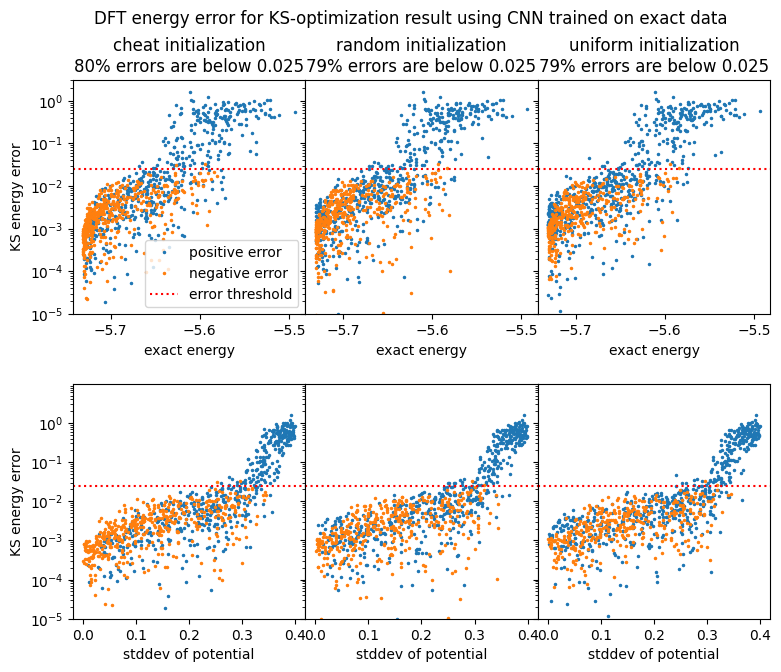

In [17]:
fig = energy_error_plots(source = EXACT, error_threshold = 0.025)
fig.suptitle(f"DFT energy error for KS-optimization result using CNN trained on exact data");

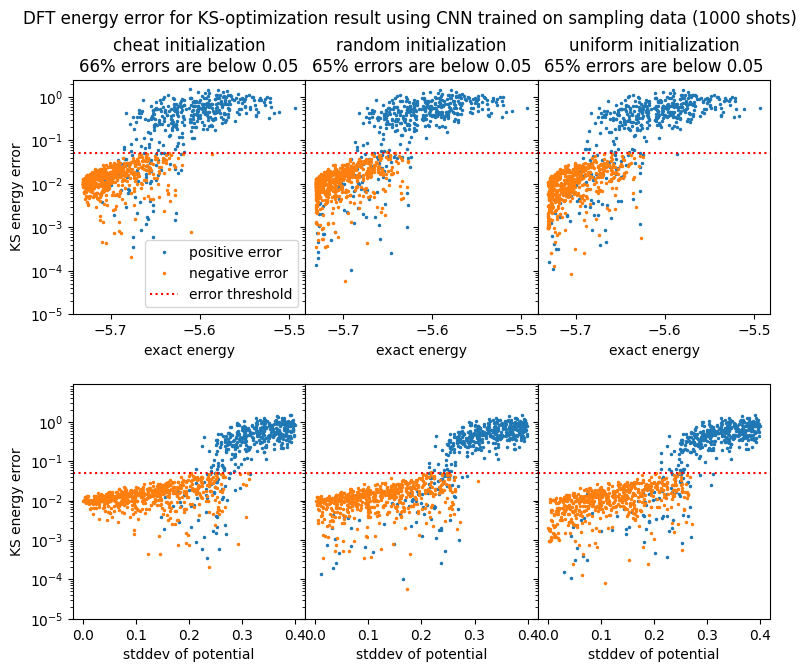

In [18]:
nshots = 1000
fig = energy_error_plots(source=f"sampling/nshots{nshots}", error_threshold=0.05)
fig.suptitle(
    f"DFT energy error for KS-optimization result using CNN trained on sampling data ({nshots} shots)"
);

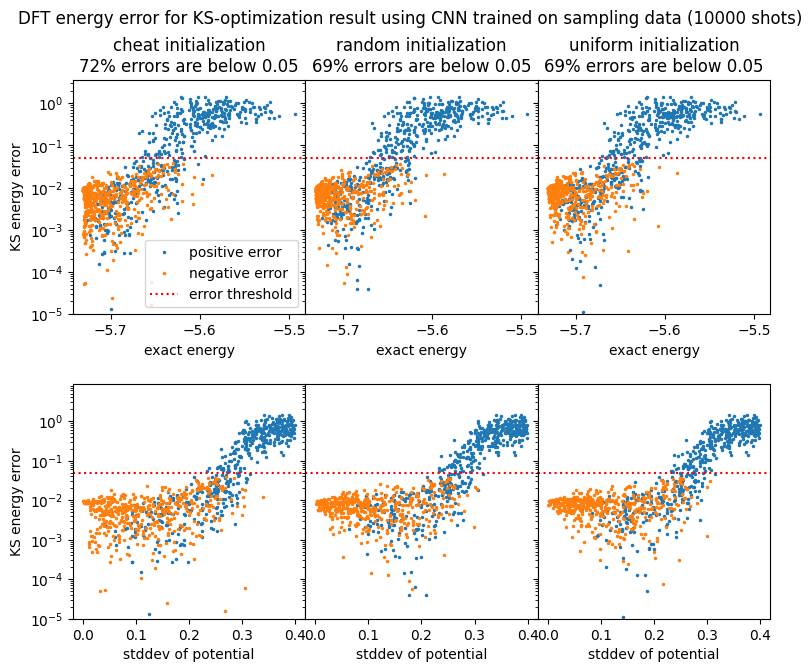

In [19]:
nshots = 10000
fig = energy_error_plots(source=f"sampling/nshots{nshots}", error_threshold=0.05)
fig.suptitle(
    f"DFT energy error for KS-optimization result using CNN trained on sampling data ({nshots} shots)"
);

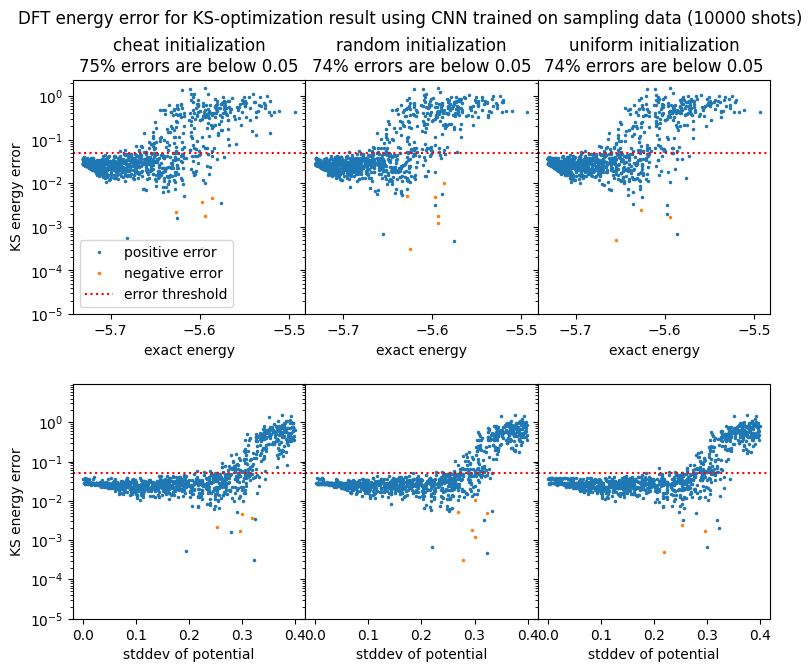

In [20]:
depth = 8
fig = energy_error_plots(source=f"npfabric-vqe/depth{depth}", error_threshold=0.05)
fig.suptitle(
    f"DFT energy error for KS-optimization result using CNN trained on sampling data ({nshots} shots)"
);

## Density error

In [21]:
def density_error_plots(source, error_threshold):
    ms = 3
    fig, axes = plt.subplots(1, len(INITS), figsize=(9, 4), sharey = 'row')

    for i, init in enumerate(INITS):
        ks_densities, ks_energies = load_ks(L, N, U, source, init, 0, potentials=potentials)
        density_errors = np.sqrt(np.sum((ks_densities - exact_densities)**2, axis=1))
        npts_below_threshold = np.sum(np.abs(density_errors) < error_threshold)

        axes[i].set_title(f'{init} initialization\n'
                            f'{npts_below_threshold/N_DATA_TEST:.0%} errors are below {error_threshold}')
        
        axes[i].plot(potential_std, density_errors, ".", ms=ms)

        axes[i].axhline(0, color="black", ls=":")
        axes[i].axhline(error_threshold, color="red", ls=":", label='error threshold')
        axes[i].set_xlabel("stddev of potential")

    axes[0].set_ylabel("KS density error")
    axes[0].legend()
    axes[0].set_yscale("log")
    axes[0].set_ylim(bottom=1e-3)
    
    plt.subplots_adjust(wspace=0)
    return fig

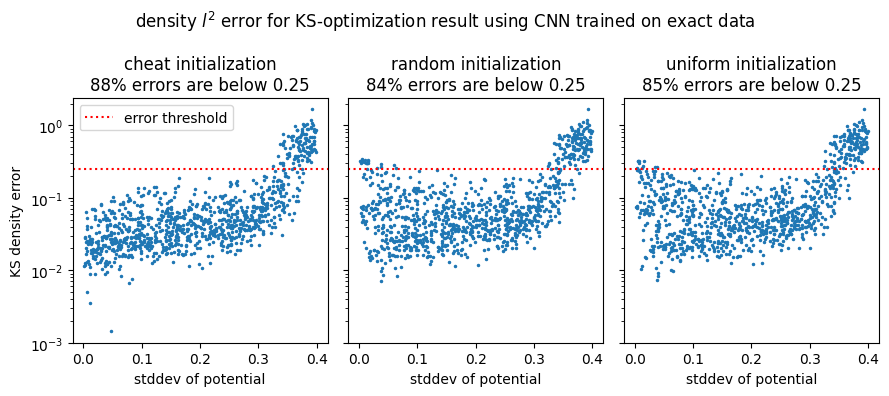

In [22]:
fig = density_error_plots(source = EXACT, error_threshold = 0.25)
fig.suptitle(f"density $l^2$ error for KS-optimization result using CNN trained on exact data")
plt.tight_layout()

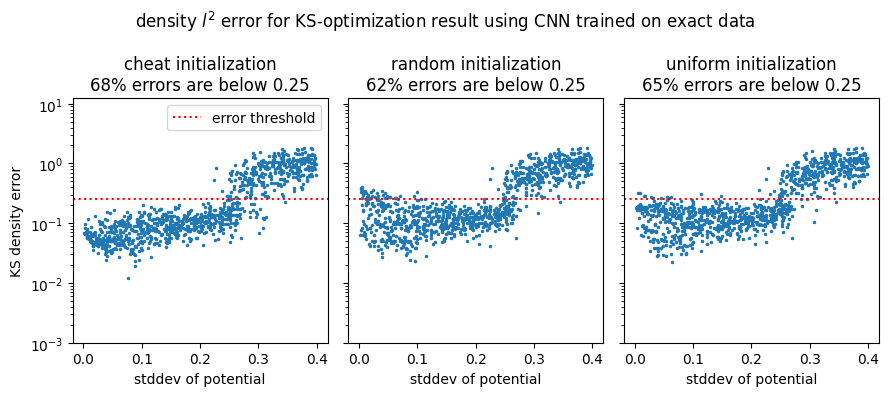

In [23]:
nshots = 1000
fig = density_error_plots(source=f"sampling/nshots{nshots}", error_threshold=0.25)
fig.suptitle(f"density $l^2$ error for KS-optimization result using CNN trained on exact data")
plt.tight_layout()

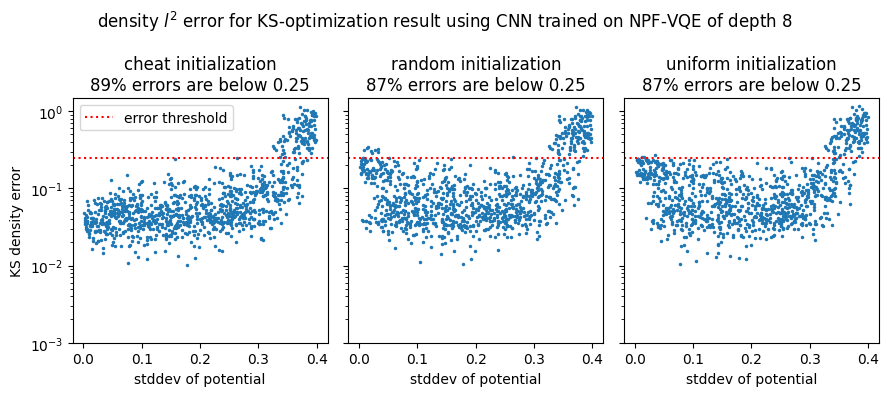

In [24]:
depth = 8
fig = density_error_plots(source=f"npfabric-slsqp-init/depth{depth}", error_threshold=0.25)
fig.suptitle(f"density $l^2$ error for KS-optimization result using CNN trained on NPF-VQE of depth {depth}")
plt.tight_layout()

## Comparison

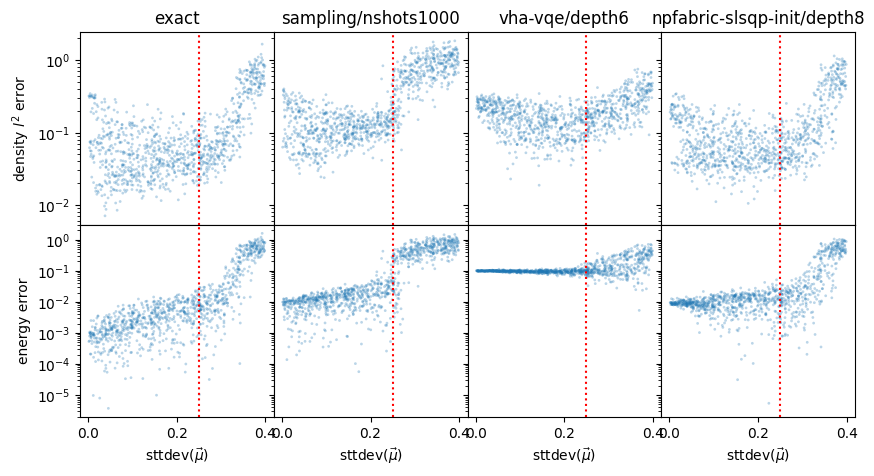

In [25]:
init = "random"
sources = ["exact", "sampling/nshots1000", "vha-vqe/depth6", "npfabric-slsqp-init/depth8"]
split = 0

ms=4
alpha=0.3

fig, axes = plt.subplots(2, len(sources), figsize=(2.5*len(sources), 5), sharey = 'row', sharex=True)

for i, source in enumerate(sources):
    ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials)
    density_errors = np.sqrt(np.sum((ks_densities - exact_densities)**2, axis=1))
    energy_errors = np.abs(ks_energies - exact_energies)

    axes[0, i].scatter(potential_std, density_errors, s=ms, alpha=alpha, ec='none')
    axes[1, i].scatter(potential_std, energy_errors, s=ms, alpha=alpha, ec='none')
    
    axes[1, i].set_xlabel(r'sttdev($\vec{\mu}$)')
    axes[0, i].set_title(source)
    
    axes[0, i].axvline(0.25, color='red', ls=':')
    axes[1, i].axvline(0.25, color='red', ls=':')


axes[0, 0].set_yscale('log')
axes[0, 0].set_ylabel('density $l^2$ error')
axes[1, 0].set_yscale('log')
axes[1, 0].set_ylabel('energy error')
plt.subplots_adjust(wspace=0, hspace=0)

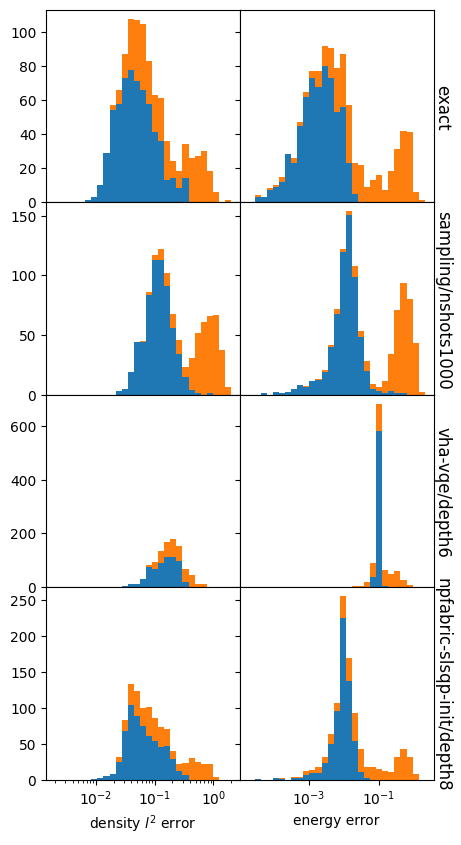

In [26]:
import numpy as np

init = "random"
sources = ["exact", "sampling/nshots1000", "vha-vqe/depth6", "npfabric-slsqp-init/depth8"]
split = 0
pot_std_threshold = 0.25

num_bins = 30
density_error_range = [0.002, 2]
energy_error_range = [0.00002, 2]

# Create log-spaced bins
density_bins = np.logspace(
    np.log10(density_error_range[0]), np.log10(density_error_range[1]), num_bins
)
energy_bins = np.logspace(
    np.log10(energy_error_range[0]), np.log10(energy_error_range[1]), num_bins
)

fig, axes = plt.subplots(
    len(sources), 2, figsize=(5, 2.5 * len(sources)), sharey='row', sharex="col"
)

mask = potential_std < pot_std_threshold

for i, source in enumerate(sources):
    ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials)
    density_errors = np.sqrt(np.sum((ks_densities - exact_densities) ** 2, axis=1))
    energy_errors = np.abs(ks_energies - exact_energies)

    axes[i, 0].hist(density_errors[mask], bins=density_bins, zorder=2)
    axes[i, 1].hist(energy_errors[mask], bins=energy_bins, zorder=2)

    axes[i, 0].hist(density_errors, bins=density_bins)
    axes[i, 1].hist(energy_errors, bins=energy_bins)

    axes[i, 0].set_xlabel(r"sttdev($\vec{\mu}$)")
    axes[i, 1].set_title(source, rotation=270, x=1,  y=0.45, ha='left', va='center')

axes[0, 0].set_xscale("log")
axes[-1, 0].set_xlabel("density $l^2$ error")
axes[0, 1].set_xscale("log")
axes[-1, 1].set_xlabel("energy error")
plt.subplots_adjust(wspace=0, hspace=0)

In [27]:
plt.rcParams.find_all('title')

RcParams({'axes.titlecolor': 'auto',
          'axes.titlelocation': 'center',
          'axes.titlepad': 6.0,
          'axes.titlesize': 'large',
          'axes.titleweight': 'normal',
          'axes.titley': None,
          'figure.titlesize': 'large',
          'figure.titleweight': 'normal',
          'legend.title_fontsize': None})

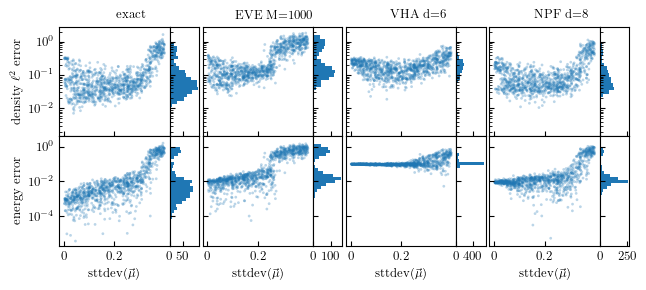

In [29]:
plt.style.use(os.path.join(DFTQML_PATH,'notebooks/figstyle.mplstyle'))
hsize = 7.4

fig, axes = plt.subplots(
    2,
    len(sources) * 2,
    figsize=(hsize, hsize/(2.5 * len(sources) * 1.3)*5),
    sharey="row",
    sharex="col",
    gridspec_kw={"width_ratios": len(sources) * [10, 3], 'hspace':0, 'wspace':0},
)

# Create log-spaced bins
density_bins = np.logspace(
    np.log10(density_error_range[0]), np.log10(density_error_range[1]), num_bins
)
energy_bins = np.logspace(
    np.log10(energy_error_range[0]), np.log10(energy_error_range[1]), num_bins
)

titles = ["exact", "EVE M=1000", "VHA d=6", "NPF d=8"]

for i, source in enumerate(sources):
    ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials)
    density_errors = np.sqrt(np.sum((ks_densities - exact_densities) ** 2, axis=1))
    energy_errors = np.abs(ks_energies - exact_energies)

    axes[0, i * 2].scatter(potential_std, density_errors, s=ms, alpha=alpha, ec="none")
    axes[1, i * 2].scatter(potential_std, energy_errors, s=ms, alpha=alpha, ec="none")

    axes[0, i * 2 + 1].hist(
        density_errors, orientation="horizontal", bins=density_bins
    )
    axes[1, i * 2 + 1].hist(energy_errors, orientation="horizontal", bins=energy_bins)

    axes[1, i * 2].set_xlabel(r"sttdev($\vec{\mu}$)")
    axes[0, i * 2].set_title(titles[i], x=0.65)

    #axes[0, i * 2].axvline(0.25, color="red", ls=":")
    #axes[1, i * 2].axvline(0.25, color="red", ls=":")
   
    axes[1, i * 2].set_xticks([0, 0.2,], ['0','0.2'])

axes[1, 1].set_xticks([0, 50])
axes[1, 5].set_xticks([0, 400])

axes[0, 0].set_yscale("log")
axes[0, 0].set_ylabel("density $\ell^2$ error")
axes[1, 0].set_yscale("log")
axes[1, 0].set_ylabel("energy error")

# plt.subplots_adjust(wspace=0, hspace=0)

# Add space between specific subplots
for i in range(1, len(sources) * 2, 2):
    for j in range(2):
        box = axes[j, i].get_position()
        box.x0 -= 0.00  # Add space to the left of the subplot
        box.x1 -= 0.005  # Add space to the right of the subplot
        axes[j, i].set_position(box)

# plt.savefig("kohn-sham.pdf", bbox_inches="tight")

# Harmonic potentials

## Energy error

In [6]:
def energy_error_plots(source, error_threshold, split=0):
    ms = 3
    fig, axes = plt.subplots(2, len(INITS), figsize=(9, 7), sharey = 'row')

    for i, init in enumerate(INITS):
        ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials, harmonic=True)
        energy_errors = ks_energies - harmonic_energies
        npts_below_threshold = np.sum(np.abs(energy_errors) < error_threshold)
        
        axes[0, i].plot(harmonic_energies, energy_errors, ".", ms=ms, label = 'positive error')
        axes[0, i].plot(harmonic_energies, -energy_errors, ".", ms=ms, label = 'negative error')
        axes[0, i].axhline(0, color="black", ls=":")
        axes[0, i].axhline(error_threshold, color="red", ls=":", label='error threshold')
        axes[0, i].axhline(-error_threshold, color="red", ls=":")
        axes[0, i].set_xlabel("exact energy")
        
        axes[0, i].set_title(f'{init} initialization\n'
                            f'{npts_below_threshold/N_HARMONIC:.0%} errors are below {error_threshold}')
        
        axes[1, i].plot(strengths, energy_errors, ".", ms=ms)
        axes[1, i].plot(strengths, -energy_errors, ".", ms=ms)
        axes[1, i].axhline(0, color="black", ls=":")
        axes[1, i].axhline(error_threshold, color="red", ls=":", label='error threshold')
        axes[1, i].set_xlabel(r"$\lambda$")

    axes[0, 0].set_ylabel("KS energy error")
    axes[0, 0].legend()
    axes[0, 0].set_yscale("log")
    axes[0, 0].set_ylim(bottom=1e-5)

    axes[1, 0].set_ylabel("KS energy error")
    axes[1, 0].set_yscale("log")
    axes[1, 0].set_ylim(bottom=1e-5)

    plt.subplots_adjust(wspace=0, hspace=0.3)
    return fig

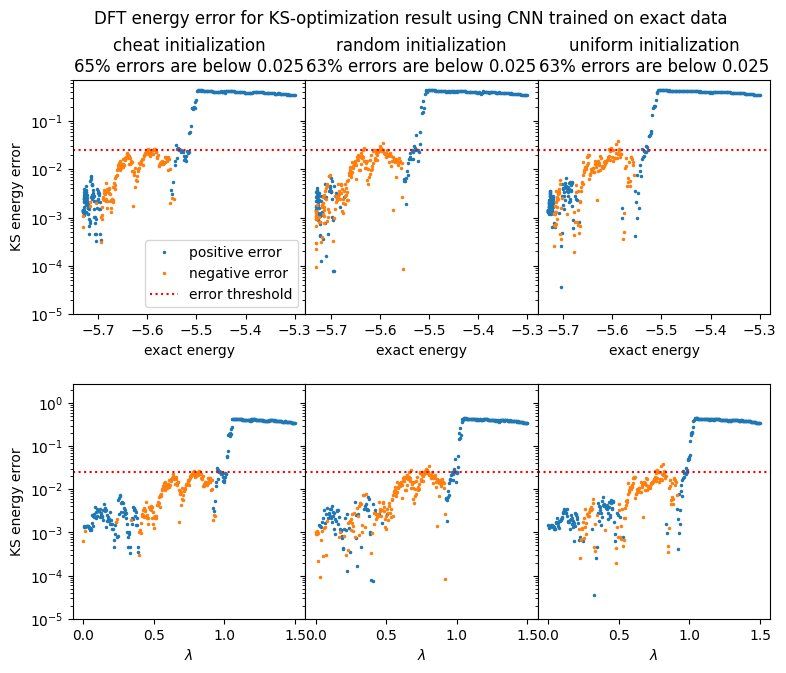

In [7]:
fig = energy_error_plots(source = EXACT, error_threshold = 0.025)
fig.suptitle(f"DFT energy error for KS-optimization result using CNN trained on exact data");

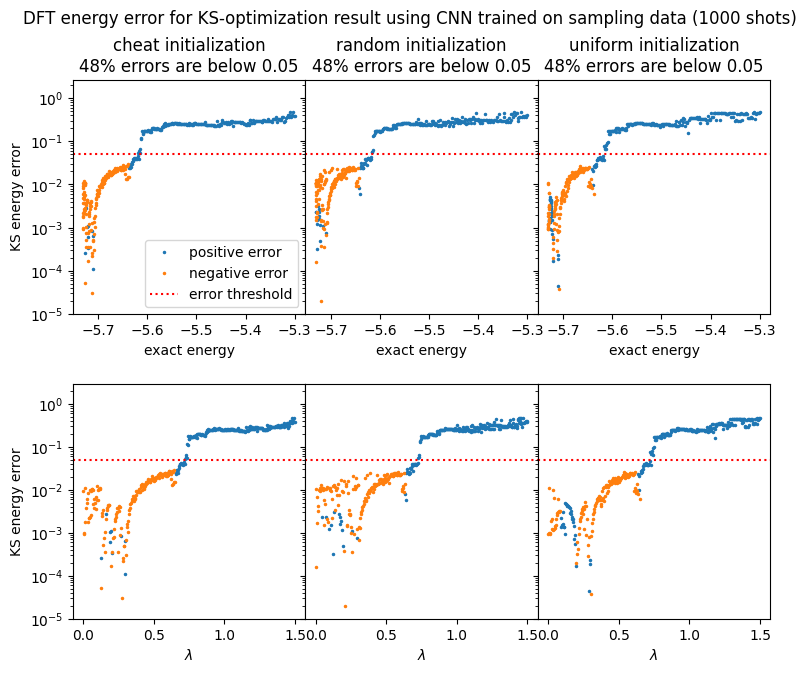

In [8]:
nshots = 1000
fig = energy_error_plots(source=f"sampling/nshots{nshots}", error_threshold=0.05)
fig.suptitle(
    f"DFT energy error for KS-optimization result using CNN trained on sampling data ({nshots} shots)"
);

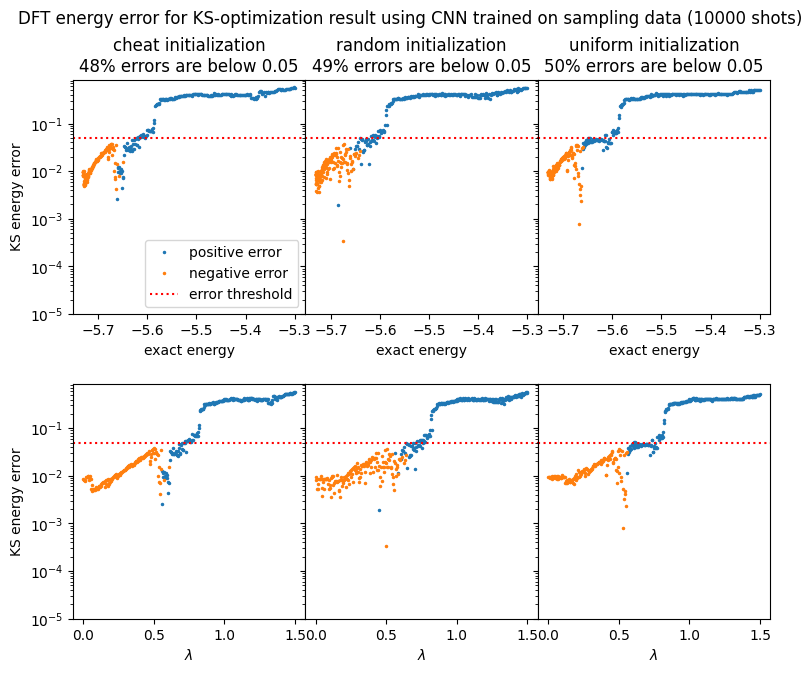

In [9]:
nshots = 10000
fig = energy_error_plots(source=f"sampling/nshots{nshots}", error_threshold=0.05)
fig.suptitle(
    f"DFT energy error for KS-optimization result using CNN trained on sampling data ({nshots} shots)"
);

Text(0.5, 0.98, 'DFT energy error for KS-optimization result using CNN trained on np-fabric VQE of depth 8')

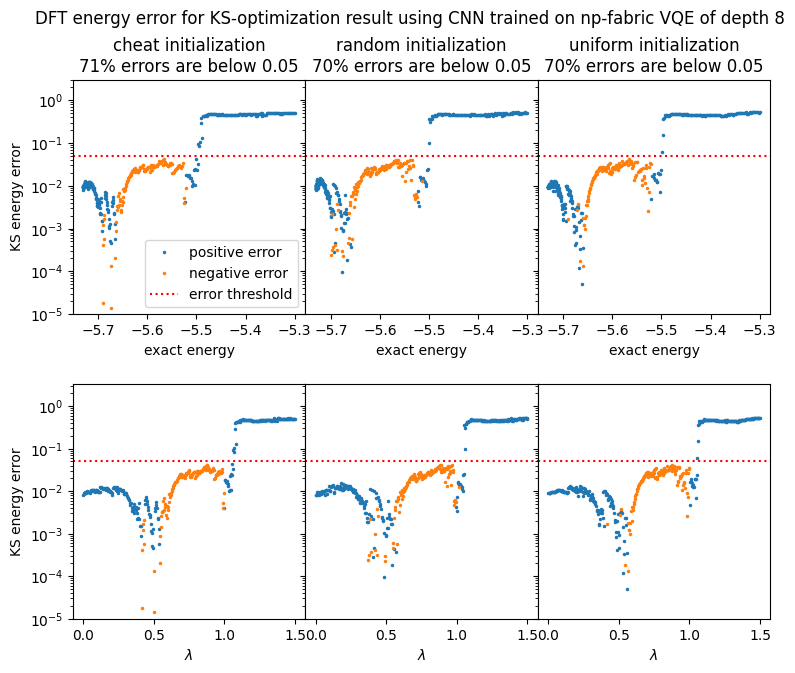

In [10]:
depth = 8
fig = energy_error_plots(source=f"npfabric-slsqp-init/depth{depth}", error_threshold=0.05)
fig.suptitle(
    f"DFT energy error for KS-optimization result using CNN trained on np-fabric VQE of depth {depth}")

## Density error

In [11]:
def density_error_plots(source, error_threshold):
    ms = 3
    fig, axes = plt.subplots(1, len(INITS), figsize=(9, 4), sharey = 'row')

    for i, init in enumerate(INITS):
        ks_densities, ks_energies = load_ks(L, N, U, source, init, 0, potentials=potentials, harmonic=True)
        density_errors = np.sqrt(np.sum((ks_densities - harmonic_densities)**2, axis=1))
        npts_below_threshold = np.sum(np.abs(density_errors) < error_threshold)

        axes[i].set_title(f'{init} initialization\n'
                            f'{npts_below_threshold/N_HARMONIC:.0%} errors are below {error_threshold}')
        
        axes[i].plot(strengths, density_errors, ".", ms=ms)

        axes[i].axhline(0, color="black", ls=":")
        axes[i].axhline(error_threshold, color="red", ls=":", label='error threshold')
        axes[i].set_xlabel(r"$\lambda$")

    axes[0].set_ylabel("KS density error")
    axes[0].legend()
    axes[0].set_yscale("log")
    axes[0].set_ylim(bottom=1e-3)
    
    plt.subplots_adjust(wspace=0)
    return fig

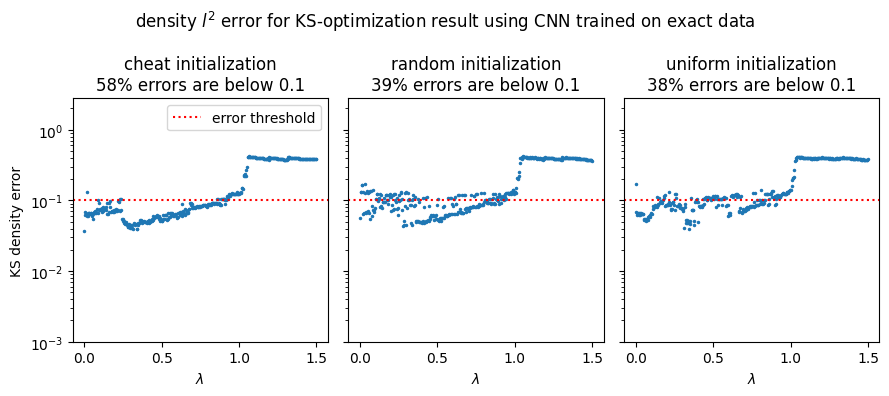

In [12]:
fig = density_error_plots(source = EXACT, error_threshold = 0.1)
fig.suptitle(f"density $l^2$ error for KS-optimization result using CNN trained on exact data")
plt.tight_layout()

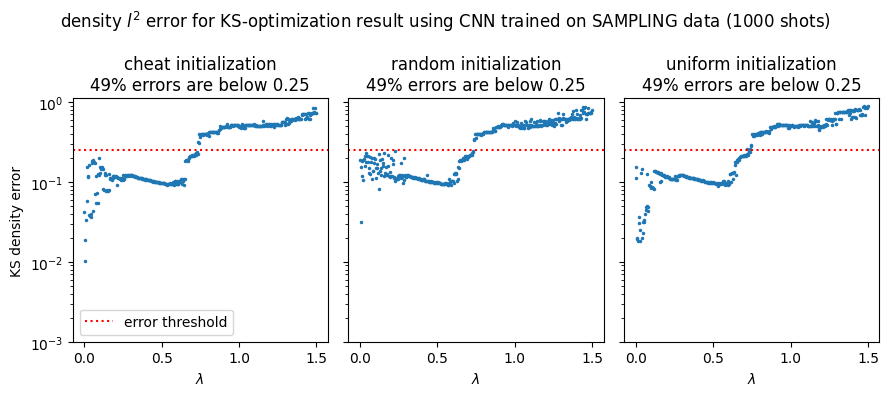

In [13]:
nshots = 1000
fig = density_error_plots(source=f"sampling/nshots{nshots}", error_threshold=0.25)
fig.suptitle(f"density $l^2$ error for KS-optimization result using CNN trained on SAMPLING data ({nshots} shots)")
plt.tight_layout()

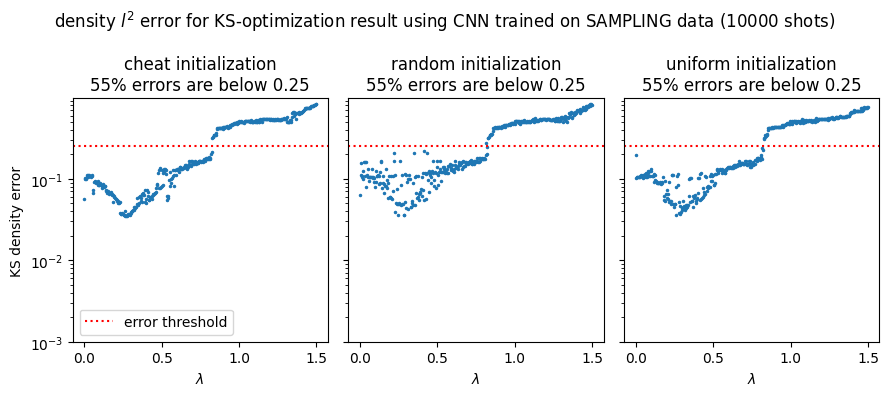

In [14]:
nshots = 10000
fig = density_error_plots(source=f"sampling/nshots{nshots}", error_threshold=0.25)
fig.suptitle(f"density $l^2$ error for KS-optimization result using CNN trained on SAMPLING data ({nshots} shots)")
plt.tight_layout()

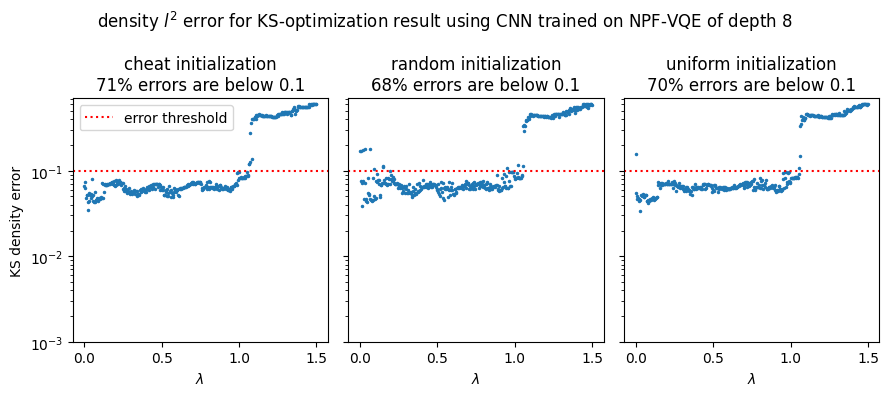

In [15]:
depth = 8
fig = density_error_plots(source=f"npfabric-slsqp-init/depth{depth}", error_threshold=0.1)
fig.suptitle(f"density $l^2$ error for KS-optimization result using CNN trained on NPF-VQE of depth {depth}")
plt.tight_layout()

## Comparison

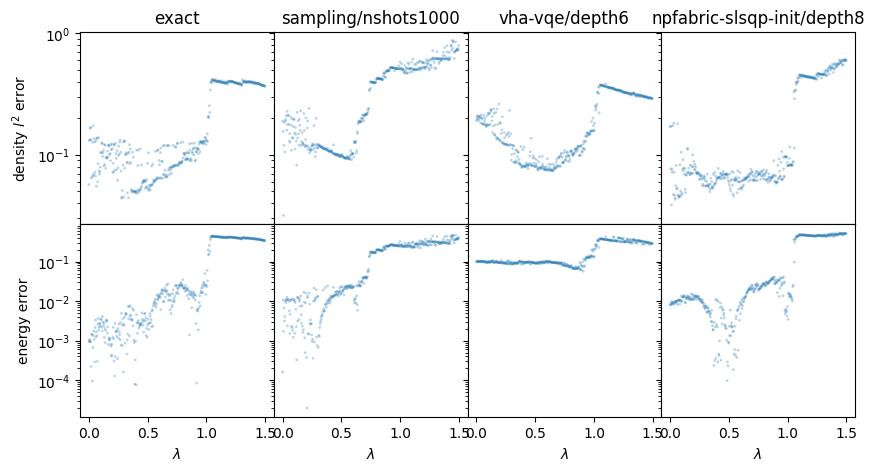

In [16]:
init = "random"
sources = ["exact", "sampling/nshots1000", "vha-vqe/depth6", "npfabric-slsqp-init/depth8"]
split = 0

ms=4
alpha=0.3

fig, axes = plt.subplots(2, len(sources), figsize=(2.5*len(sources), 5), sharey = 'row', sharex=True)

for i, source in enumerate(sources):
    ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials, harmonic=True)
    density_errors = np.sqrt(np.sum((ks_densities - harmonic_densities)**2, axis=1))
    energy_errors = np.abs(ks_energies - harmonic_energies)

    axes[0, i].scatter(strengths, density_errors, s=ms, alpha=alpha, ec='none')
    axes[1, i].scatter(strengths, energy_errors, s=ms, alpha=alpha, ec='none')
    
    axes[1, i].set_xlabel(r'$\lambda$')
    axes[0, i].set_title(source)
    
    # axes[0, i].axvline(0.25, color='red', ls=':')
    # axes[1, i].axvline(0.25, color='red', ls=':')


axes[0, 0].set_yscale('log')
axes[0, 0].set_ylabel('density $l^2$ error')
axes[1, 0].set_yscale('log')
axes[1, 0].set_ylabel('energy error')
plt.subplots_adjust(wspace=0, hspace=0)

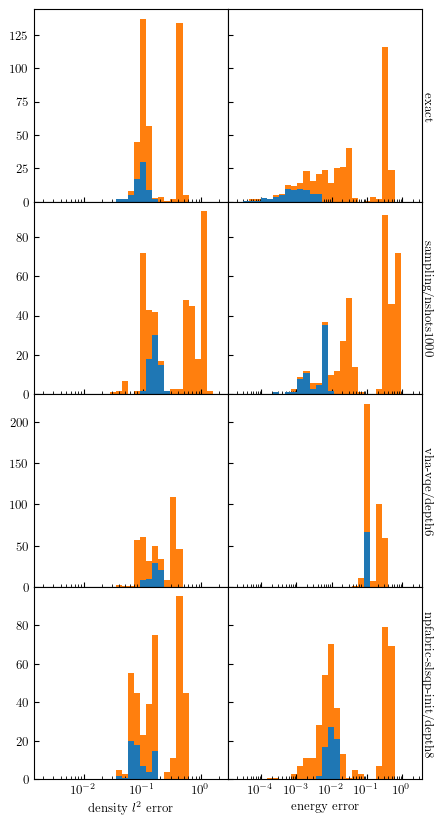

In [39]:
import numpy as np

init = "random"
sources = ["exact", "sampling/nshots1000", "vha-vqe/depth6", "npfabric-slsqp-init/depth8"]
split = 1
pot_std_threshold = 0.25

num_bins = 30
density_error_range = [0.002, 2]
energy_error_range = [0.00002, 2]

# Create log-spaced bins
density_bins = np.logspace(
    np.log10(density_error_range[0]), np.log10(density_error_range[1]), num_bins
)
energy_bins = np.logspace(
    np.log10(energy_error_range[0]), np.log10(energy_error_range[1]), num_bins
)

fig, axes = plt.subplots(
    len(sources), 2, figsize=(5, 2.5 * len(sources)), sharey='row', sharex="col"
)

# mask = potential_std < pot_std_threshold
mask = strengths < pot_std_threshold

for i, source in enumerate(sources):
    ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials, harmonic=True)
    density_errors = np.sqrt(np.sum((ks_densities - harmonic_densities) ** 2, axis=1))
    energy_errors = np.abs(ks_energies - harmonic_energies)

    axes[i, 0].hist(density_errors[mask], bins=density_bins, zorder=2)
    axes[i, 1].hist(energy_errors[mask], bins=energy_bins, zorder=2)

    axes[i, 0].hist(density_errors, bins=density_bins)
    axes[i, 1].hist(energy_errors, bins=energy_bins)

    axes[i, 0].set_xlabel(r"$\lambda$")
    axes[i, 1].set_title(source, rotation=270, x=1,  y=0.45, ha='left', va='center')

axes[0, 0].set_xscale("log")
axes[-1, 0].set_xlabel("density $l^2$ error")
axes[0, 1].set_xscale("log")
axes[-1, 1].set_xlabel("energy error")
plt.subplots_adjust(wspace=0, hspace=0)

In [18]:
plt.rcParams.find_all('title')

RcParams({'axes.titlecolor': 'auto',
          'axes.titlelocation': 'center',
          'axes.titlepad': 6.0,
          'axes.titlesize': 'large',
          'axes.titleweight': 'normal',
          'axes.titley': None,
          'figure.titlesize': 'large',
          'figure.titleweight': 'normal',
          'legend.title_fontsize': None})

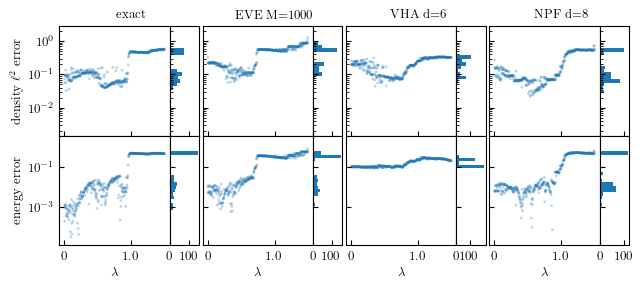

In [45]:
plt.style.use(os.path.join(DFTQML_PATH,'notebooks/figstyle.mplstyle'))
hsize = 7.4
num_bins = 30
split = 4

fig, axes = plt.subplots(
    2,
    len(sources) * 2,
    figsize=(hsize, hsize/(2.5 * len(sources) * 1.3)*5),
    sharey="row",
    sharex="col",
    gridspec_kw={"width_ratios": len(sources) * [10, 3], 'hspace':0, 'wspace':0},
)

# Create log-spaced bins
density_bins = np.logspace(
    np.log10(density_error_range[0]), np.log10(density_error_range[1]), num_bins
)
energy_bins = np.logspace(
    np.log10(energy_error_range[0]), np.log10(energy_error_range[1]), num_bins
)

titles = ["exact", "EVE M=1000", "VHA d=6", "NPF d=8"]

for i, source in enumerate(sources):
    ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials, harmonic=True)
    density_errors = np.sqrt(np.sum((ks_densities - harmonic_densities) ** 2, axis=1))
    energy_errors = np.abs(ks_energies - harmonic_energies)

    axes[0, i * 2].scatter(strengths, density_errors, s=ms, alpha=alpha, ec="none")
    axes[1, i * 2].scatter(strengths, energy_errors, s=ms, alpha=alpha, ec="none")

    axes[0, i * 2 + 1].hist(
        density_errors, orientation="horizontal", bins=density_bins
    )
    axes[1, i * 2 + 1].hist(energy_errors, orientation="horizontal", bins=energy_bins)


    # axes[1, i * 2 + 1].set_ylim(0,100)

    axes[1, i * 2].set_xlabel(r"$\lambda$")
    axes[0, i * 2].set_title(titles[i], x=0.65)

    #axes[0, i * 2].axvline(0.25, color="red", ls=":")
    #axes[1, i * 2].axvline(0.25, color="red", ls=":")
   
    # axes[1, i * 2].set_xticks([0, 0.2,], ['0','0.2'])
    axes[1, i * 2].set_xticks([0, np.around(strengths[len(strengths)//2]),], ['0',str(np.around(strengths[len(strengths)//2]))])

# axes[1, 1].set_xticks([0, 50])
axes[1, 5].set_xticks([0, 100])

axes[0, 0].set_yscale("log")
axes[0, 0].set_ylabel("density $\ell^2$ error")
axes[1, 0].set_yscale("log")
axes[1, 0].set_ylabel("energy error")

# plt.subplots_adjust(wspace=0, hspace=0)

# Add space between specific subplots
for i in range(1, len(sources) * 2, 2):
    for j in range(2):
        box = axes[j, i].get_position()
        box.x0 -= 0.00  # Add space to the left of the subplot
        box.x1 -= 0.005  # Add space to the right of the subplot
        axes[j, i].set_position(box)

plt.savefig(os.path.join(DFTQML_PATH, "notebooks", f"kohn-sham_harmonic_{split}.pdf"), bbox_inches="tight")

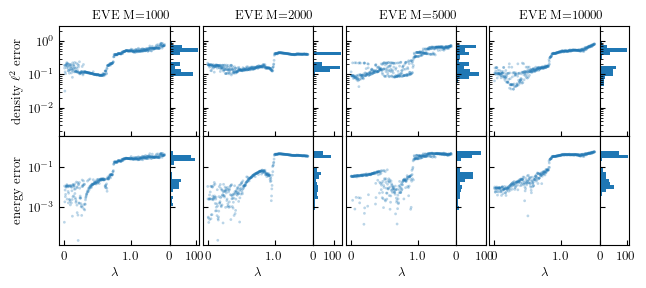

In [36]:
plt.style.use(os.path.join(DFTQML_PATH,'notebooks/figstyle.mplstyle'))
hsize = 7.4

# sources = ["exact", 
sources =   [f"sampling/nshots{shots}" for shots in [1000,2000,5000,10000]]#, "sampling/nshots5000", "sampling/nshots10000"]
            # "vha-vqe/depth6", "npfabric-slsqp-init/depth8"]
titles = [f"EVE M={shots}" for shots in [1000,2000,5000,10000]]#,"EVE M=5000","EVE M=10000"]#,
        #    "VHA d=6", "NPF d=8"]
num_bins = 30
fig, axes = plt.subplots(
    2,
    len(sources) * 2,
    figsize=(hsize, hsize/(2.5 * len(sources) * 1.3)*5),
    sharey="row",
    sharex="col",
    gridspec_kw={"width_ratios": len(sources) * [10, 3], 'hspace':0, 'wspace':0},
)

# Create log-spaced bins
density_bins = np.logspace(
    np.log10(density_error_range[0]), np.log10(density_error_range[1]), num_bins
)
energy_bins = np.logspace(
    np.log10(energy_error_range[0]), np.log10(energy_error_range[1]), num_bins
)



for i, source in enumerate(sources):
    ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials, harmonic=True)
    density_errors = np.sqrt(np.sum((ks_densities - harmonic_densities) ** 2, axis=1))
    energy_errors = np.abs(ks_energies - harmonic_energies)

    axes[0, i * 2].scatter(strengths, density_errors, s=ms, alpha=alpha, ec="none")
    axes[1, i * 2].scatter(strengths, energy_errors, s=ms, alpha=alpha, ec="none")

    axes[0, i * 2 + 1].hist(
        density_errors, orientation="horizontal", bins=density_bins
    )
    axes[1, i * 2 + 1].hist(energy_errors, orientation="horizontal", bins=energy_bins)


    # axes[1, i * 2 + 1].set_ylim(0,100)

    axes[1, i * 2].set_xlabel(r"$\lambda$")
    axes[0, i * 2].set_title(titles[i], x=0.65)

    #axes[0, i * 2].axvline(0.25, color="red", ls=":")
    #axes[1, i * 2].axvline(0.25, color="red", ls=":")
   
    # axes[1, i * 2].set_xticks([0, 0.2,], ['0','0.2'])
    axes[1, i * 2].set_xticks([0, np.around(strengths[len(strengths)//2]),], ['0',str(np.around(strengths[len(strengths)//2]))])

# axes[1, 1].set_xticks([0, 50])
axes[1, 5].set_xticks([0, 100])

axes[0, 0].set_yscale("log")
axes[0, 0].set_ylabel("density $\ell^2$ error")
axes[1, 0].set_yscale("log")
axes[1, 0].set_ylabel("energy error")

# plt.subplots_adjust(wspace=0, hspace=0)

# Add space between specific subplots
for i in range(1, len(sources) * 2, 2):
    for j in range(2):
        box = axes[j, i].get_position()
        box.x0 -= 0.00  # Add space to the left of the subplot
        box.x1 -= 0.005  # Add space to the right of the subplot
        axes[j, i].set_position(box)

plt.savefig(os.path.join(DFTQML_PATH, "notebooks", "kohn-sham_harmonic_EVE_high.pdf"), bbox_inches="tight")

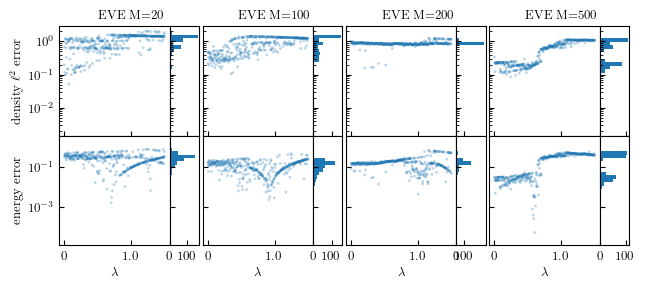

In [38]:
plt.style.use(os.path.join(DFTQML_PATH,'notebooks/figstyle.mplstyle'))
hsize = 7.4

# sources = ["exact", 
sources =   [f"sampling/nshots{shots}" for shots in [20, 100, 200, 500]]#, "sampling/nshots5000", "sampling/nshots10000"]
            # "vha-vqe/depth6", "npfabric-slsqp-init/depth8"]
titles = [f"EVE M={shots}" for shots in [20, 100, 200, 500]]#,"EVE M=5000","EVE M=10000"]#,
        #    "VHA d=6", "NPF d=8"]
num_bins = 30
fig, axes = plt.subplots(
    2,
    len(sources) * 2,
    figsize=(hsize, hsize/(2.5 * len(sources) * 1.3)*5),
    sharey="row",
    sharex="col",
    gridspec_kw={"width_ratios": len(sources) * [10, 3], 'hspace':0, 'wspace':0},
)

# Create log-spaced bins
density_bins = np.logspace(
    np.log10(density_error_range[0]), np.log10(density_error_range[1]), num_bins
)
energy_bins = np.logspace(
    np.log10(energy_error_range[0]), np.log10(energy_error_range[1]), num_bins
)



for i, source in enumerate(sources):
    ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials, harmonic=True)
    density_errors = np.sqrt(np.sum((ks_densities - harmonic_densities) ** 2, axis=1))
    energy_errors = np.abs(ks_energies - harmonic_energies)

    axes[0, i * 2].scatter(strengths, density_errors, s=ms, alpha=alpha, ec="none")
    axes[1, i * 2].scatter(strengths, energy_errors, s=ms, alpha=alpha, ec="none")

    axes[0, i * 2 + 1].hist(
        density_errors, orientation="horizontal", bins=density_bins
    )
    axes[1, i * 2 + 1].hist(energy_errors, orientation="horizontal", bins=energy_bins)


    # axes[1, i * 2 + 1].set_ylim(0,100)

    axes[1, i * 2].set_xlabel(r"$\lambda$")
    axes[0, i * 2].set_title(titles[i], x=0.65)

    #axes[0, i * 2].axvline(0.25, color="red", ls=":")
    #axes[1, i * 2].axvline(0.25, color="red", ls=":")
   
    # axes[1, i * 2].set_xticks([0, 0.2,], ['0','0.2'])
    axes[1, i * 2].set_xticks([0, np.around(strengths[len(strengths)//2]),], ['0',str(np.around(strengths[len(strengths)//2]))])

# axes[1, 1].set_xticks([0, 50])
axes[1, 5].set_xticks([0, 100])

axes[0, 0].set_yscale("log")
axes[0, 0].set_ylabel("density $\ell^2$ error")
axes[1, 0].set_yscale("log")
axes[1, 0].set_ylabel("energy error")

# plt.subplots_adjust(wspace=0, hspace=0)

# Add space between specific subplots
for i in range(1, len(sources) * 2, 2):
    for j in range(2):
        box = axes[j, i].get_position()
        box.x0 -= 0.00  # Add space to the left of the subplot
        box.x1 -= 0.005  # Add space to the right of the subplot
        axes[j, i].set_position(box)

plt.savefig(os.path.join(DFTQML_PATH, "notebooks", "kohn-sham_harmonic_EVE_low.pdf"), bbox_inches="tight")

In [24]:
strengths[len(strengths)//2]

0.7509386733416771